<a href="https://colab.research.google.com/github/thaisrezendeb/ufes_machineLearning/blob/main/Exercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3) Dada a base de dados Breast Cancer Wisconsin (Diagnostic) (baixar em
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)):

**a) Obtenha a acurácia de classificação quando usando o classificador vizinho mais
próximo (NN) (utilize a distância Euclidiana). Use os dados do arquivo wdbc.data,
sendo as primeiras 300 amostras para treino e as demais para teste. Antes, repare os
atributos da base de dados e a posição dos rótulos. Quais atributos você pode eliminar
da base de dados antes do experimento? Por quê?**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def vizinho(base_train, base_test):
  acuracia = 0

  #Cálculo da distância Euclidiana
  #Verifica a distância de cada amostra da base de teste com cada uma das amostras da base de treinamento
  for i, row in base_test.iterrows():
    dist_min = 1000000
    classif_new = row[0]
    
    for j, row_next in base_train.iterrows():
      dist = 0
      for k in range(1, base_test.shape[1]-1):
        dist = dist + np.power(row_next[k]-row[k],2)

      dist = np.sqrt(dist)
      if dist < dist_min:
        dist_min = dist
        classif_new = row_next[0]
    
    if row[0] == classif_new:
      acuracia = acuracia + 1

  acuracia = np.divide(acuracia, base_test.shape[0])

  return acuracia

wdbc = pd.read_csv("wdbc.data", sep=",", header=None)
#wdbc.head()

Pela descrição da base de dados, observa-se que apenas o ID é um atributo que pode ser eliminado. Demais atributos contêm informações técnicas que somente poderiam ser eliminadas com o auxílio de um especialista.

In [ ]:
wdbc_pre = wdbc.drop(0, axis=1)
wdbc_pre.columns = range(wdbc_pre.shape[1])
wdbc_train = wdbc_pre[:300]
wdbc_test = wdbc_pre[300:]
#wdbc_train.to_csv("wdbc_train.data", sep=",", index=None)

In [ ]:
ac_viz = vizinho(wdbc_train, wdbc_test)
print("Acurácia NN: {:.2f}%".format(ac_viz*100))

Acurácia NN: 88.48%


A acurácia apresentada na classificação pelo vizinho maisi próximo (NN) foi de **88,48%**.

**b) gere dois gráficos 2D com os dois componentes principais (uso de PCA) das amostras,
identificando cada classe. Para um dos gráficos, obtenha o PCA a partir da matriz de
covariância e para o outro realize o branqueamento dos dados (isto é, após a aplicação
do PCA garantir que a matriz de covariância dos dados seja uma matriz identidade). O
que tem de diferente entre os gráficos? A que conclusão você chegou?**

In [ ]:
def pca_(base_train, pos_class = 0, n_comp = 2, whiten=False, corr=False):

  global autovalores
  global M

  #Remove coluna com dados de classificação
  base_train_noclass = base_train.drop(pos_class, axis=1)
  base_train_noclass.columns = range(base_train_noclass.shape[1])

  #Cálculo das médias para cada componente
  medias_base_train_noclass = np.mean(base_train_noclass, axis=0)
  
  dv = 1
  #Usar matriz de coeficientes de correlação
  if corr == True:
    dv = np.std(base_train_noclass, axis=0)

  #Faz a normalização dos valores
  base_train_noclass_norm = ((base_train_noclass - medias_base_train_noclass) / dv)
  
  #Calcula a matriz de covariância dos componentes normalizados
  C = base_train_noclass_norm.T.dot(base_train_noclass_norm) \
                                           / (base_train_noclass_norm.shape[0]-1)

  #Obtém os autovalores e autovetores
  autovalores, autovetores = np.linalg.eig(C)  

  #Monta uma matriz contendo duas colunas: a primeira o autovalor e a segunda seu respectivo autovetor
  matriz_auto = [
                (
                    autovalores[i],
                    autovetores[:,i]
                ) for i in range(len(autovalores))
  ]

  #Ordena matriz de forma decrescente
  df_auto = pd.DataFrame(matriz_auto)
  df_auto.sort_values(by=0, ascending=False, inplace=True)
  #df_auto.head()
  matriz_auto = df_auto.to_numpy()

  autovetores_ord = [p[1] for p in matriz_auto]

  #Seleciona autovetores
  M = autovetores_ord[0:n_comp]
  
  #Reapresenta as amostras nos novos eixos
  novo_base_train_noclass = np.dot(base_train_noclass_norm, np.array(M).T)
  
  #Branqueamento dos dados
  if whiten == True:
    matriz_white = np.diag(autovalores[:n_comp]**(-1/2)).T
    novo_base_train_noclass = np.dot(novo_base_train_noclass, matriz_white)

  #Devolve classe para as amostras
  novo_base_train = pd.concat([base_train[pos_class], \
                               pd.DataFrame(novo_base_train_noclass)], \
                               axis=1, \
                               ignore_index=True)
  
  return novo_base_train

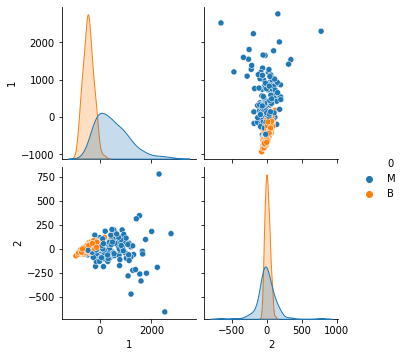

In [ ]:
#Monta novo dataframe com amostras em novos eixos para o gráfico
#usando matriz de covariância
novo_wdbc_train = pca_(wdbc_train, pos_class=0)
#print(novo_wdbc_train)
sns.pairplot(novo_wdbc_train, hue=0)

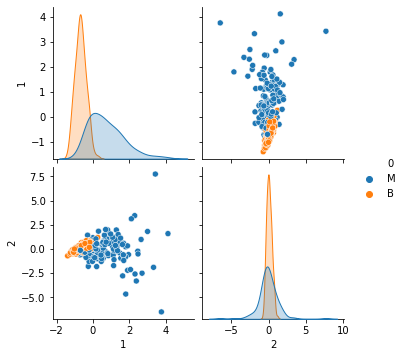

In [ ]:
#Monta novo dataframe com amostras em novos eixos para o gráfico
#usando dados branqueados
novo_wdbc_train = pca_(wdbc_train, pos_class=0, whiten=True)
sns.pairplot(novo_wdbc_train, hue=0)

Ao comparar os gráficos sem e com branqueamento, percebe-se que os eixos foram reajustados e reduzidos em sua amplitude sem perder o formato da distribuição. Com o branqueamento obtém-se uma padronização na escala de ambos os eixos, o que permite uma melhor análise dos dados.

In [ ]:
##Código para teste
#from sklearn.decomposition import PCA

#X = wdbc_train.drop(0, axis=1)
#X.columns = range(X.shape[1])
#Y = wdbc_train[0]

#pca = PCA(n_components=2, whiten=True)
#pca.fit(X)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#print(pca.explained_variance_)
#X = pca.transform(X)
#new_df = pd.DataFrame(X, columns=["pc1", "pc2"])
#new_df["target"] = Y
#sns.pairplot(new_df, vars=["pc1", "pc2"], hue="target")

**c) Aplique o PCA sobre os dados de treino e selecione o número de componentes até eles corresponderem a 90% da informação de variância dos dados (conforme mostrado nos slides). Realize este procedimento 2 vezes (uma com a matriz de covariância e outra com a matriz de coeficientes de correlação). Quantos componentes foram selecionados? Calcule a nova acurácia do NN usando as
componentes selecionadas. O resultado alterou de forma significativa em relação ao obtido em a)? Qual foi a vantagem observada usando PCA? O que você observou
comparando os dois métodos?**

In [ ]:
#Usando a matriz de covariância para obter valores acumulados dos autovalores
novo_wdbc_train = pca_(wdbc_train, pos_class=0, whiten=True, n_comp=30)
perc_info = autovalores[0] / autovalores.sum()
i = 1
while perc_info < 0.9:
  perc_info = (autovalores[0:i].sum()) / autovalores.sum()
  i += 1
print("Componentes: {} \nInfo: {:.2f}%".format(i, perc_info*100))

Componentes: 1 
Info: 97.60%


In [ ]:
#Usando a matriz de coeficientes de correlação para obter 
#valores acumulados dos autovalores
novo_wdbc_train = pca_(wdbc_train, pos_class=0, whiten=True, n_comp=30, corr=True)
perc_info = autovalores[0] / autovalores.sum()
i = 1
while perc_info < 0.9:
  perc_info = (autovalores[0:i].sum()) / autovalores.sum()
  i += 1
print("Componentes: {} \nInfo: {:.2f}%".format(i, perc_info*100))

Componentes: 8 
Info: 90.70%


Quando utilizada a matriz de covariância, percebe-se que apenas uma das componentes já possui quase a totalidade das informações (**97,6%**), mesmo com dados branqueados. Já quando se calcula o PCA pela matriz de coeficientes de correlação, há um maior espalhamento da informação, sendo necessárias **8 componentes** para corresponder a um valor acima de 90% da informação (**90,7%**).

In [ ]:
#Recalculando a base de treinamento para 90% da informação
novo_wdbc_train = pca_(wdbc_train, pos_class=0, whiten=True, n_comp=i, corr=True)

#Transformando a base de teste no novo plano
wdbc_train_noclass = wdbc_train.drop(0, axis=1)
wdbc_train_noclass.columns = range(wdbc_train_noclass.shape[1])

wdbc_test_noclass = wdbc_test.drop(0, axis=1)
wdbc_test_noclass.columns = range(wdbc_test_noclass.shape[1])

wdbc_test_noclass_norm = ((wdbc_test_noclass - wdbc_train_noclass.mean()) \
                            / np.std(wdbc_train_noclass, axis=0))
novo_wdbc_test_noclass_norm = np.dot(wdbc_test_noclass_norm, np.array(M).T)

#Devolve classe para as amostras
novo_wdbc_test = pd.concat([wdbc_test.reset_index()[0], \
                            pd.DataFrame(novo_wdbc_test_noclass_norm)], \
                           axis=1, \
                           ignore_index=True)

ac_viz = vizinho(novo_wdbc_train, novo_wdbc_test)
print("Acurácia com {} componentes: {:.2f}%".format(i, ac_viz*100))

Acurácia com 8 componentes: 95.17%


In [ ]:
#Pelo critério de Kaiser
autovalores_kaiser = autovalores[autovalores > 1]
print(autovalores_kaiser)
print("Nr. componentes por Kaiser: {}".format(np.size(autovalores_kaiser)))

[13.06338364  5.77713335  3.25519859  1.81411581  1.4904386   1.22127142]
Nr. componentes por Kaiser: 6


A acurácia obtida com os 8 primeiros elementos, correspondente a mais de 90% da informação foi de **95,17%**. Porém, obervou-se que a melhor acurácia foi com **6 componentes** (96,28%), que corresponde ao valor encontrado pelo **critério de Kaiser**.

**d) Aplique o Discriminante Linear de Fisher sobre os dados de treino e obtenha a acurácia
do NN sobre o conjunto de teste. Quais as vantagens desta abordagem sobre o PCA?**

In [ ]:
#Cálculo das médias da classe  M
wdbc_m = wdbc_train[wdbc_train[0] == 'M']
wdbc_m_noclass = wdbc_m.drop(0, axis=1)
wdbc_m_noclass.columns = range(wdbc_m_noclass.shape[1])
wdbc_m_noclass.reset_index(drop=True, inplace=True)
medias_m = wdbc_m_noclass.mean()

#Cálculo das médias da classe  B
wdbc_b = wdbc_train[wdbc_train[0] == 'B']
wdbc_b_noclass = wdbc_b.drop(0, axis=1)
wdbc_b_noclass.columns = range(wdbc_b_noclass.shape[1])
wdbc_b_noclass.reset_index(drop=True, inplace=True)
medias_b = wdbc_b_noclass.mean()

#Cálculo do vetor de Fisher
s1 = (wdbc_m_noclass.shape[0] - 1) * wdbc_m_noclass.cov()
s2 = (wdbc_b_noclass.shape[0] - 1) * wdbc_b_noclass.cov()
Sw = s1.add(s2)
Sw_inv = np.linalg.inv(Sw)
v = np.dot(Sw_inv, (medias_m - medias_b))

#Projeção das amostras no vetor de Fisher
vt = pd.DataFrame(v).T

m_fisher = pd.DataFrame(columns=range(wdbc_m_noclass.shape[1]), \
                        index=range(wdbc_m_noclass.shape[0]))
for i,row in wdbc_m_noclass.iterrows():
  m_fisher.iloc[i] = np.array(vt * row.T)

wdbc_fisher_m = pd.concat([pd.DataFrame('M' for x in range(m_fisher.shape[0])), \
                        m_fisher], \
                        axis=1, \
                        ignore_index=True)

b_fisher = pd.DataFrame(columns=range(wdbc_b_noclass.shape[1]), \
                        index=range(wdbc_b_noclass.shape[0]))
for i,row in wdbc_b_noclass.iterrows():
  b_fisher.iloc[i] = np.array(vt * row.T)

wdbc_fisher_b = pd.concat([pd.DataFrame('B' for x in range(b_fisher.shape[0])), \
                        b_fisher], \
                        axis=1, \
                        ignore_index=True)

#Reagrupamento dos dados de treinamento
wdbc_fisher_train = pd.concat([wdbc_fisher_b, wdbc_fisher_m], axis=0, ignore_index=True)

#Projeção das amostras de teste no discriminante de Fisher
wdbc_m = wdbc_test[wdbc_test[0] == 'M']
wdbc_m_noclass = wdbc_m.drop(0, axis=1)
wdbc_m_noclass.columns = range(wdbc_m_noclass.shape[1])
wdbc_m_noclass.reset_index(drop=True, inplace=True)

wdbc_b = wdbc_test[wdbc_test[0] == 'B']
wdbc_b_noclass = wdbc_b.drop(0, axis=1)
wdbc_b_noclass.columns = range(wdbc_b_noclass.shape[1])
wdbc_b_noclass.reset_index(drop=True, inplace=True)

m_fisher = pd.DataFrame(columns=range(wdbc_m_noclass.shape[1]), \
                        index=range(wdbc_m_noclass.shape[0]))
for i,row in wdbc_m_noclass.iterrows():
  m_fisher.iloc[i] = np.array(vt * row.T)

wdbc_fisher_m = pd.concat([pd.DataFrame('M' for x in range(m_fisher.shape[0])), \
                        m_fisher], \
                        axis=1, \
                        ignore_index=True)

b_fisher = pd.DataFrame(columns=range(wdbc_b_noclass.shape[1]), \
                        index=range(wdbc_b_noclass.shape[0]))

for i,row in wdbc_b_noclass.iterrows():
  b_fisher.iloc[i] = np.array(vt * row.T)

wdbc_fisher_b = pd.concat([pd.DataFrame('B' for x in range(b_fisher.shape[0])), \
                        b_fisher], \
                        axis=1, \
                        ignore_index=True)

#Reagrupamento dos dados de treinamento
wdbc_fisher_test = pd.concat([wdbc_fisher_b, wdbc_fisher_m], axis=0, ignore_index=True)

ac_viz = vizinho(wdbc_fisher_train, wdbc_fisher_test)
print("Acurácia NN discriminante Fisher: {:.2f}%".format(ac_viz*100))

Acurácia NN discriminante Fisher: 93.31%


A acurácia na classificação pelo método do vizinho mais próximo usando as amostras projetadas no Discriminante de Fisher apresentou um resultado de **93,31%**, ligeiramente inferior ao valor apresentado pelo método PCA. Este método tende a funcionar melhor quando os dados possuem uma separação linear. O PCA fornece uma boa representação dos dados, mas não necessariamente uma discriminação entre as classes. O PCA tenta representar os dados de acordo com a variância dos dados, fazendo uma compactação. Já o Fisher procura a direção que melhore a separação dos dados.